### Installing dependencies from conda. Only have to run it once! Takes some time. You can do something else for 20 minutes. Specific versions of packages are not necessary to use this script, but required to reproduce the results of published segmentation

#### For CPU version

In [ ]:
#!conda create -n strubio2019 python=3.6.8 keras==2.0.8 matplotlib scikit-image jupyter -y

#### For GPU version (much faster). It probably won't work on Mac. Also, your GPU should be CUDA compatible. Check it here: https://en.wikipedia.org/wiki/CUDA#GPUs_supported. Also, you may need to update GPU drivers or use specific tensorflow version, compatible with your CUDA version. If you want to give it a try - uncomment and run the next cell. Otherwise, use CPU version.

In [ ]:
!conda create -n strubio2019 python=3.6.8 cudatoolkit==8.0 cudnn==6.0.21 keras-gpu==2.0.8 matplotlib scikit-image jupyter -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/zlo_admin/anaconda2/envs/strubio2023

  added / updated specs:
    - cudatoolkit==8.0
    - cudnn==6.0.21
    - jupyter
    - keras-gpu==2.0.8
    - matplotlib
    - python=3.6.8
    - scikit-image


The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main
  attrs              pkgs/main/noarch::attrs-19.3.0-py_0
  backcall           pkgs/main/linux-64::backcall-0.1.0-py36_0
  blas               pkgs/main/linux-64::blas-1.0-mkl
  bleach             pkgs/free/linux-64::bleach-1.5.0-py36_0
  ca-certificates    pkgs/main/linux-64::ca-certificates-2019.10.16-0
  certifi            pkgs/main/linux-64::certifi-2019.9.11-py36_0
  cloudpickle        pkgs/main/noarch::cloudpickle-1.2.2-p

Preparing transaction: done
Verifying transaction: done
Executing transaction: done
#
# To activate this environment, use
#
#     $ conda activate strubio2023
#
# To deactivate an active environment, use
#
#     $ conda deactivate



### Now you need to open jupyter notebook from new enviroment. Type in terminal "source activate strubio2019" in Linux and Mac or "conda activate strubio2019" in Anaconda Prompt in Windows. Then open jupyter by typing there "jupyter notebook". You have to do it everytime before opening this notebook

### Installing dependencies from pip. Only have to run it once!

In [1]:
!yes | pip install csbdeep==0.1.1

  Using cached https://files.pythonhosted.org/packages/55/e7/ff870322ee3645733acc5c252b238321caef4c71671a5ca3e37b030735fa/csbdeep-0.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ca/96/2fcac22c806145b34e682e03874b490ae09bc3e48013a0c77e590cd6be29/tifffile-2019.7.26-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e1/c1/bc1dba38b48f4ae3c4428aea669c5e27bd5a7642a74c8348451e0bd8ff86/tqdm-4.36.1-py2.py3-none-any.whl
yes: standard output: Broken pipe
yes: write error


### Allocating fraction of total GPU memory for neural networks (NN) if GPU is used

In [1]:
from csbdeep.utils.tf import limit_gpu_memory
limit_gpu_memory(fraction=7/10)

Using TensorFlow backend.


AttributeError: module 'keras.backend.tensorflow_backend' has no attribute '_SESSION'

### Here you have to specify the directories with your training and validation datasets

In [76]:
basepath='data/side/'
training_original_dir='training/original/'
training_ground_truth_dir='training/ground_truth/'
validation_original_dir='validation/original/'
validation_ground_truth_dir='validation/ground_truth/'

### Loading files and plot examples. Run it only once for each new dataset

Training dataset's number of files and dimensions:  19 (256, 256) 19 (256, 256)
Validation dataset's number of files and dimensions:  3 (256, 256) 3 (256, 256)


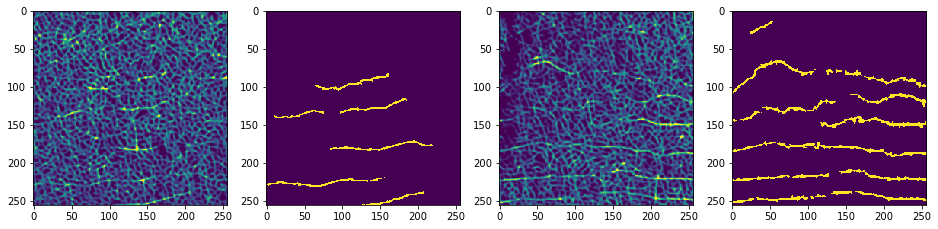

In [77]:
import glob
from skimage import io
from matplotlib import pyplot as plt
training_original_files=sorted(glob.glob(basepath+training_original_dir+'*.tif'))
training_original_file=io.imread(training_original_files[0])
training_ground_truth_files=sorted(glob.glob(basepath+training_ground_truth_dir+'*.tif'))
training_ground_truth_file=io.imread(training_ground_truth_files[0])
print("Training dataset's number of files and dimensions: ",len(training_original_files), training_original_file.shape, len(training_ground_truth_files), training_ground_truth_file.shape)
training_size=len(training_original_file)

validation_original_files=sorted(glob.glob(basepath+validation_original_dir+'*.tif'))
validation_original_file=io.imread(validation_original_files[0])
validation_ground_truth_files=sorted(glob.glob(basepath+validation_ground_truth_dir+'*.tif'))
validation_ground_truth_file=io.imread(validation_ground_truth_files[0])
print("Validation dataset's number of files and dimensions: ",len(validation_original_files), validation_original_file.shape, len(validation_ground_truth_files), validation_ground_truth_file.shape)
validation_size=len(validation_original_file)

if training_size==validation_size:
    size=training_size
else:
    print('Training and validation images should be of the same dimensions!')

plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(training_original_file)
plt.subplot(142)
plt.imshow(training_ground_truth_file)
plt.subplot(143)
plt.imshow(validation_original_file)
plt.subplot(144)
plt.imshow(validation_ground_truth_file)

### Preparing input for NNs from pairs of 32bit TIFF image files with intensities in range 0..1. . Run it only once for each new dataset

In [78]:
#basepath='data/side/'
from csbdeep.data import RawData, create_patches, no_background_patches
training_data = RawData.from_folder (
basepath    = basepath,
source_dirs = [training_original_dir],
target_dir  = training_ground_truth_dir,
axes        = 'YX',
)

validation_data = RawData.from_folder (
basepath    = basepath,
source_dirs = [validation_original_dir],
target_dir  = validation_ground_truth_dir,
axes        = 'YX',
)

# pathces will be created further in "data augmentation" step, 
# that's why patch size here is the dimensions of images and number of pathes per image is 1
X, Y, XY_axes = create_patches (
raw_data            = training_data,
patch_size          = (size,size),
patch_filter        = no_background_patches(0),
n_patches_per_image = 1,
save_file           = basepath+'training.npz',
)

X_val, Y_val, XY_axes = create_patches (
raw_data            = validation_data,
patch_size          = (size,size),
patch_filter        = no_background_patches(0),
n_patches_per_image = 1,
save_file           = basepath+'validation.npz',
)

   19 raw images x    1 transformations   =    19 images
   19 images     x    1 patches per image =    19 patches in total
Input data:
data/side/: target='training/ground_truth/', sources=['training/original/'], axes='YX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
256 x 256


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 59.47it/s]


Saving data to data\side\training.npz.
    3 raw images x    1 transformations   =     3 images
    3 images     x    1 patches per image =     3 patches in total
Input data:
data/side/: target='validation/ground_truth/', sources=['validation/original/'], axes='YX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
256 x 256


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 59.84it/s]


Saving data to data\side\validation.npz.


### Loading training and validation data into memory

In [79]:
from csbdeep.io import load_training_data
(X,Y), _, axes = load_training_data(basepath+'training.npz', verbose=False)
(X_val,Y_val), _, axes = load_training_data(basepath+'validation.npz', verbose=False)
X.shape, Y.shape, X_val.shape, Y_val.shape
from csbdeep.utils import axes_dict
c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

### Preparing data augmentation generator. Parameters of "data_gen_args" can be adjusted for specific problem

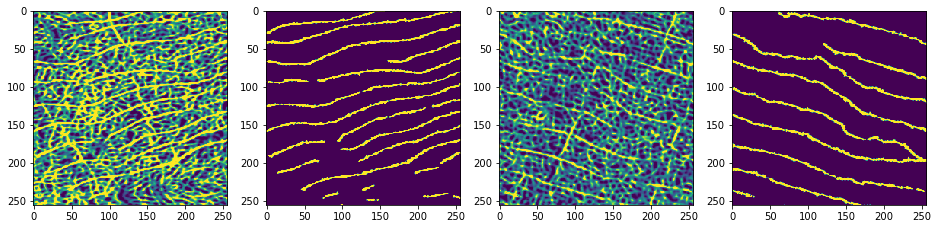

In [80]:
batch=len(X) # You should define number of batches according to the available memory
#batch=1
seed = 1
from keras.preprocessing.image import ImageDataGenerator
data_gen_args = dict(samplewise_center=False,
    samplewise_std_normalization=False,
    brightness_range=[0,5],
    rotation_range=40,
    zca_whitening=False,
    fill_mode='reflect',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    )

# training
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(X, augment=True, seed=seed)
mask_datagen.fit(Y, augment=True, seed=seed)
image_generator = image_datagen.flow(X,batch_size=batch,seed=seed)
mask_generator = mask_datagen.flow(Y,batch_size=batch,seed=seed)
generator = zip(image_generator, mask_generator)

# validation
image_datagen_val = ImageDataGenerator(**data_gen_args)
mask_datagen_val = ImageDataGenerator(**data_gen_args)
image_datagen_val.fit(X_val, augment=True, seed=seed)
mask_datagen_val.fit(Y_val, augment=True, seed=seed)
image_generator_val = image_datagen_val.flow(X_val,batch_size=batch,seed=seed)
mask_generator_val = mask_datagen_val.flow(Y_val,batch_size=batch,seed=seed)
generator_val = zip(image_generator_val, mask_generator_val)

# plot examples
x,y = generator.__next__()
x_val,y_val = generator_val.__next__()

plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(x[0,:,:,0])
plt.subplot(142)
plt.imshow(y[0,:,:,0])
plt.subplot(143)
plt.imshow(x_val[0,:,:,0])
plt.subplot(144)
plt.imshow(y_val[0,:,:,0])

### Here you have to specify your hyperparameters. Better to start with low number of blocks and channels and high learning rate

In [81]:
size=32
X=X.reshape(X.shape[:3])[:,:size,:size]
Y=Y.reshape(Y.shape[:3])[:,:size,:size]
X_val=X_val.reshape(X_val.shape[:3])[:,:size,:size]
Y_val=Y_val.reshape(Y_val.shape[:3])[:,:size,:size]

In [62]:
#print(X.shape) # (60000, 28, 28)
#print(Y.shape) # (60000,)
#print(X[:3])
#print(Y[:3]) # array([7, 2, 1], dtype=uint8)

In [82]:
Y=Y.reshape(Y.shape[0], Y.shape[1]*Y.shape[2])
Y_val=Y_val.reshape(Y_val.shape[0], Y_val.shape[1]*Y_val.shape[2])

In [83]:
X.shape, Y.shape, X_val.shape, Y_val.shape

((19, 32, 32), (19, 1024), (3, 32, 32), (3, 1024))

In [ ]:
import autokeras as ak

# Initialize the image classifier.
clf = ak.ImageRegressor(max_trials=2) # It tries 2 different models.
# Feed the image classifier with training data.
clf.fit(X, Y, epochs=10, validation_split=0.2)
# Predict with the best model.
predicted_y = clf.predict(X_val)
# Evaluate the best model with testing data.
print(clf.evaluate(X_val, Y_val))

Train for 1 steps, validate for 1 steps
Epoch 1/10
1/1 [==============================] - 1s 677ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.1110 - val_mean_squared_error: 0.1110
Epoch 2/10
1/1 [==============================] - 0s 197ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.1105 - val_mean_squared_error: 0.1105
Epoch 3/10
1/1 [==============================] - 0s 209ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.1099 - val_mean_squared_error: 0.1099
Epoch 4/10
1/1 [==============================] - 0s 160ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.1091 - val_mean_squared_error: 0.1091
Epoch 5/10
1/1 [==============================] - 0s 157ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - val_loss: 0.1080 - val_mean_squared_error: 0.1080
Epoch 6/10
1/1 [==============================] - 0s 163ms/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.1068 - val_mean_squared_error: 0.1068


Train for 1 steps, validate for 1 steps
Epoch 1/10


In [47]:
predicted_y=predicted_y.reshape(predicted_y.shape[0], int(np.sqrt(predicted_y.shape[1])), int(np.sqrt(predicted_y.shape[1])) )

ValueError: cannot reshape array of size 2352 into shape (3,5,5)

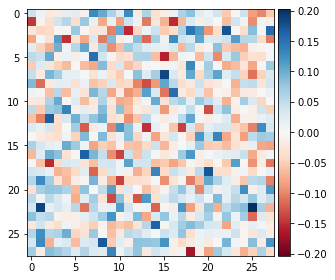

In [51]:
io.imshow(predicted_y[2])

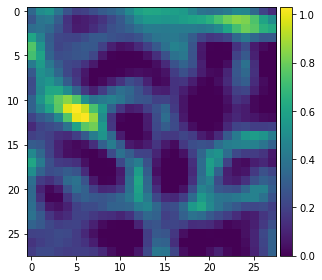

In [52]:
io.imshow(X_val[2])

In [43]:
int(np.sqrt(predicted_y.shape[1]))

28

In [7]:
import os
blocks=4
channels=128
learning_rate=0.0004
learning_rate_decay_factor=0.95
epoch_size_multiplicator=20 # basically, how often do we decrease learning rate
epochs=40

comment='_side' # adds to model_name
import datetime
model_path = f'models/{datetime.date.today().isoformat()}_{blocks}_{channels}_{learning_rate}{comment}.h5'
if os.path.isfile(model_path):
    print('Your model will be overwritten in the next cell')
kernel_size=3

### Training. May take some time, depending on your hyperparameters

In [8]:
from csbdeep.models import Config, CARE
from keras import backend as K
best_mae=1
steps_per_epoch=len(X)*epoch_size_multiplicator 
validation_steps=len(X_val)*epoch_size_multiplicator
if 'model' in globals():
    del model
if os.path.isfile(model_path):
    os.remove(model_path)
for i in range(epochs):
    print('Epoch:', i+1)
    learning_rate=learning_rate*learning_rate_decay_factor
    config = Config(axes, n_channel_in, n_channel_out, unet_kern_size=kernel_size,
                    train_learning_rate=learning_rate, unet_n_depth=blocks, unet_n_first=channels)
    model = CARE(config, '.', basedir='models')
    os.remove('models/config.json')
    if i>0:
        model.keras_model.load_weights(model_path)
    model.prepare_for_training()
    history = model.keras_model.fit_generator(generator, validation_data=generator_val, validation_steps=validation_steps, epochs=1,
                                         verbose=0, shuffle=True, steps_per_epoch=steps_per_epoch)
    if history.history['val_mae'][0]<best_mae:
        best_mae= history.history['val_mae'][0]
        if not os.path.exists('models/'):
            os.makedirs('models/')
        model.keras_model.save(model_path)
        print(f'Validation MAE:{best_mae:.3E}')
    del model
    K.clear_session()

Epoch: 1


/home/zlo_admin/anaconda2/envs/strubio2023/lib/python3.6/site-packages/csbdeep/models/care_standard.py:99: UserWarning: output path for model already exists, files may be overwritten: /mnt/data-part/Maxim_local/!script_for_paper/models
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Validation MAE:3.872E-02
Epoch: 2
Validation MAE:3.545E-02
Epoch: 3
Validation MAE:2.765E-02
Epoch: 4
Epoch: 5
Epoch: 6
Validation MAE:2.752E-02
Epoch: 7
Validation MAE:2.734E-02
Epoch: 8
Epoch: 9
Validation MAE:2.683E-02
Epoch: 10
Epoch: 11
Validation MAE:2.652E-02
Epoch: 12
Epoch: 13
Epoch: 14
Validation MAE:2.651E-02
Epoch: 15
Epoch: 16
Epoch: 17
Validation MAE:2.623E-02
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Validation MAE:2.613E-02
Epoch: 24
Epoch: 25
Validation MAE:2.577E-02
Epoch: 26
Epoch: 27
Epoch: 28
Validation MAE:2.557E-02
Epoch: 29
Epoch: 30
Validation MAE:2.553E-02
Epoch: 31
Epoch: 32
Validation MAE:2.552E-02
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Validation MAE:2.542E-02
Epoch: 39
Epoch: 40
Validation MAE:2.537E-02


### Prediction (Segmentation). Requires some variables to be defined in previous cells. The input for prediction should be again 32bit TIFF image files with intensities in range 0..1. The dimensions however do not have to match dimensions of training images. It is important, however, for each dimension to be a number divisible by 2^blocks

In [8]:
# specify path to model
model_path = 'models/2019-10-23_4_128_0.0004_side.h5'
# specify directories with images that have to be segmented 
# (32bit TIFF image files with intensities in range 0..1)
#to_segment_dir=basepath+'to_segment/'
to_segment_dir=basepath+'to_segment/'
to_segment_images_paths=sorted(glob.glob(to_segment_dir+'*.tif'))
# here you can specify which images to segment
# e. g. first, sevenths and twentieth in the directory would be [0,8,20]
# by default it is a range of all images
to_segment_images_numbers=range(len(to_segment_images_paths))
# directory where segmented images should be saved
segmented_dir=basepath+'segmented/'
if not os.path.exists(segmented_dir):
    os.makedirs(segmented_dir)
# dimensions of input will be cropped by this number. it can be any number divisible by 2^blocks
# for surface view
#input_dims = (1408,1408)
# for cross-section view
input_dims = (960,1424)

In [9]:
from csbdeep.models import Config, CARE
config = Config(axes, n_channel_in, n_channel_out, unet_kern_size=kernel_size,
                train_learning_rate=learning_rate, unet_n_depth=blocks, unet_n_first=channels)
model = CARE(config, '.', basedir='models')
os.remove('models/config.json')
model.keras_model.load_weights(model_path)

for i in to_segment_images_numbers:
    image_path = to_segment_images_paths[i]
    file_name = os.path.basename(image_path)
    #
    topred = io.imread(image_path)[:input_dims[0],:input_dims[1]]
    pred = model.keras_model.predict(topred.reshape(1,topred.shape[0],topred.shape[1],1))
    io.imsave(segmented_dir+file_name, pred[0,:,:,0])

/home/zlo_admin/anaconda2/envs/strubio2023/lib/python3.6/site-packages/csbdeep/models/care_standard.py:99: UserWarning: output path for model already exists, files may be overwritten: /mnt/data-part/Maxim_local/!script_for_paper/models
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
